<a href="https://colab.research.google.com/github/amoukrim/AI/blob/main/Week5/DailyChallenge/DailyChallenge_w5_d4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author : Adil MOUKRIM

# Daily Challenge: Stock Price Prediction with LSTM

✅ Étape 1 : Chargement et Prétraitement Initial des Données
🎯 Objectif
Charger les données

Comprendre leur structure

Nettoyer si besoin

Visualiser les prix de clôture

📦 Étape 1.1 — Chargement des données

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
df = pd.read_csv("/content/stock_market_dataset.csv")

# Afficher les 5 premières lignes du dataset
print(df.head())

# Afficher les informations générales sur le dataset
print(df.info())

           unix        date    symbol    open    high     low   close  \
0  1.640560e+12  12-27-2021  XRP-USDT  0.9200  0.9237  0.9200  0.9226   
1  1.640480e+12  12-26-2021  XRP-USDT  0.9252  0.9334  0.9052  0.9200   
2  1.640390e+12  12-25-2021  XRP-USDT  0.9114  0.9350  0.8981  0.9252   
3  1.640300e+12  12-24-2021  XRP-USDT  0.9941  0.9966  0.8964  0.9115   
4  1.640220e+12  12-23-2021  XRP-USDT  0.9538  1.0167  0.9372  0.9941   

    Volume XRP   Volume USDT  
0    2384512.0  2.198450e+06  
1  163438501.0  1.499400e+08  
2  250074945.0  2.302303e+08  
3  567234092.0  5.377035e+08  
4  479436230.0  4.729372e+08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1334 non-null   float64
 1   date         1334 non-null   object 
 2   symbol       1334 non-null   object 
 3   open         1334 non-null   float64
 4   high        

🧹 Étape 1.2 — Prétraitement de base

In [28]:
# Vérifier les colonnes disponibles
print("Colonnes du dataset:", df.columns.tolist())

# Supprimer les colonnes inutiles si besoin (par exemple 'Adj Close', 'Volume')
df = df[['date', 'close']]  # On garde uniquement la date et le prix de clôture

# Convertir la colonne 'Date' en datetime
df['date'] = pd.to_datetime(df['date'])

# Trier les données par date
df = df.sort_values('date')

# Réinitialiser les index
df.reset_index(drop=True, inplace=True)

# Vérifier les valeurs manquantes
print("Valeurs manquantes:\n", df.isnull().sum())


Colonnes du dataset: ['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume XRP', 'Volume USDT']
Valeurs manquantes:
 date     0
close    0
dtype: int64


il n'y a pas de valeurs null

📈 Étape 1.3 — Visualisation du prix de clôturepour voir la tendance générale :

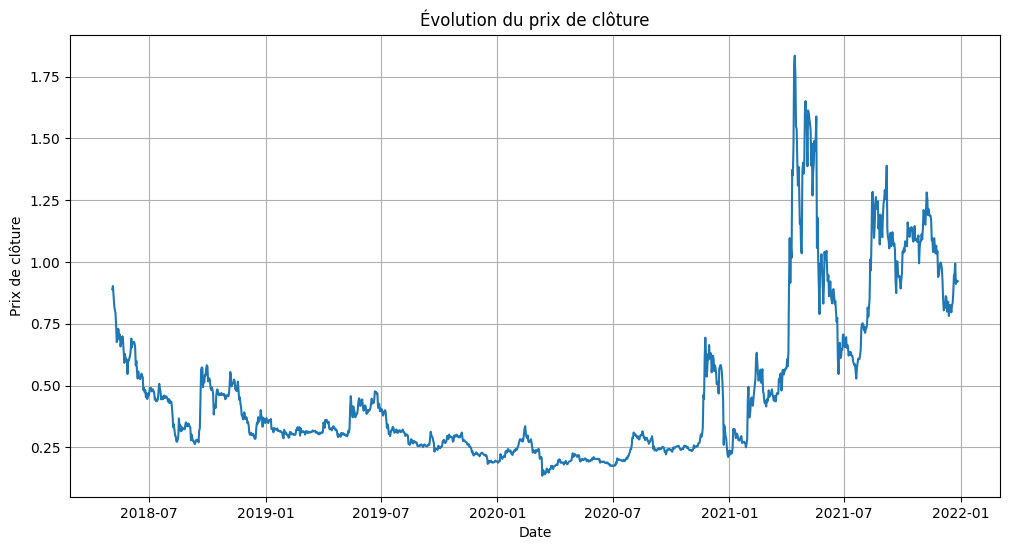

In [29]:
# Tracer l'évolution du prix de clôture
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'])
plt.title("Évolution du prix de clôture")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.grid(True)
plt.show()


📊 Interprétation du graphique : Évolution du prix de clôture
🕰️ Période observée
De début 2018 à fin 2021 (environ 4 ans de données).

🔻 Phase 1 : Baisse continue (2018 à mi-2020)
Le prix de clôture commence assez haut (autour de 0.85–0.90).

On observe une tendance baissière forte et prolongée, avec quelques rebonds techniques.

Cela peut indiquer une perte de confiance des investisseurs, des résultats négatifs ou un contexte sectoriel défavorable.

🔄 Phase 2 : Stabilisation et stagnation (mi-2019 à mi-2020)
Le prix oscille autour de 0.20–0.30, sans tendance claire.

Cette phase pourrait correspondre à une période d’attente, d’incertitude ou de consolidation avant un changement majeur.

📈 Phase 3 : Hausse spectaculaire (2020-2021)
À partir de fin 2020, le prix explose avec un pic à plus de 1.75 !

Cette phase peut résulter :

D’annonces financières majeures

D’un retournement de tendance fondamental (résultats, fusion, nouveauté technologique…)

Ou d’une spéculation intense (comme observé avec des "meme stocks")

🔻 Phase 4 : Volatilité et correction (2021)
Après le pic, les prix connaissent des hausses et baisses rapides.

Cela indique une forte volatilité : les investisseurs hésitent entre prendre leurs gains ou miser sur une poursuite de la hausse.

🧠 Conclusion pédagogique
Cette série temporelle est riche et complexe, avec plusieurs phases distinctes.

Elle est parfaitement adaptée à une modélisation par un LSTM, car ce type de réseau est bon pour capturer :

Des tendances longues (comme la chute initiale)

Des patterns courts (volatilité récente)

Et gérer la dépendance temporelle

✅ Étape 2 : Préparation des séquences pour LSTM
l'oObjectif est de Transformer la série de prix en séquences de longueur fixe (fenêtres glissantes) pour que le LSTM puisse apprendre à prédire le prix suivant.

🧱 Étape 2.1 — Normalisation et transformation en numpy
je normalise car Les réseaux de neurones (et surtout LSTM) convergent mieux quand les données sont entre 0 et 1.
 our cela j'utilise MinMaxScaler de sklearn sur la colonne 'close'.

In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extraire uniquement les prix de clôture (reshape car c’est une seule colonne)
closing_prices = df['close'].values.reshape(-1, 1)

# Appliquer la normalisation MinMax (entre 0 et 1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)


🔄 Étape 2.2 — Création des séquences
Je transforme la en un ensemble de séquences glissantes pour la prédiction.

In [31]:
# Longueur de chaque séquence d'entrée (nombre de jours pour prédire le suivant)
sequence_length = 60

# Listes pour stocker les séquences
X = []
y = []

# Créer les séquences
for i in range(sequence_length, len(scaled_prices)):
    X.append(scaled_prices[i-sequence_length:i])  # séquence des 60 jours
    y.append(scaled_prices[i])                    # valeur cible (le jour suivant)

# Convertir en tableaux numpy
X = np.array(X)
y = np.array(y)

# Afficher les formes pour vérification
print("Forme de X (séquences) :", X.shape)
print("Forme de y (cibles) :", y.shape)


Forme de X (séquences) : (1274, 60, 1)
Forme de y (cibles) : (1274, 1)


Il y a 1274 séquences de 60 jours glissants (X)

et 1274 cibles correspondant au prix du jour suivant (y)

C’est suffisant pour entraîner un LSTM.

▶️ Étape 3 : Création d’un Dataset et DataLoader PyTorch
l'Objectif st de :

* Préparer les données dans un format compatible avec PyTorch :

* Encapsuler les données dans une classe Dataset

* Les charger par batchs avec DataLoader

* Découper en ensemble d’entraînement et de test



Étape 3.1 — Création d’un Dataset personnalisé


In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

# Classe Dataset PyTorch
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        # Convertir en tenseurs PyTorch
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


Étape 3.2 — Découpage en train/test

In [33]:
# Définir le ratio d'entraînement
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

# Split des données
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Créer les datasets
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)


Étape 3.3 — Création des DataLoaders

In [34]:
# Taille des batchs (nombre de séquences traitées en parallèle)
batch_size = 64

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Afficher les tailles
print("Nombre de batchs train :", len(train_loader))
print("Nombre de batchs test  :", len(test_loader))


Nombre de batchs train : 16
Nombre de batchs test  : 4



J'ai :
* 16 batchs d’entraînement (≈ 1019 séquences, batch de 64)


* 4 batchs de test (≈ 255 séquences restantes)

Tout est bien préparé pour entraîner un modèle LSTM.

Étape 5 : Évaluer le modèle LSTM
L'Obje ctifs est :


* Utiliser le modèle entraîné pour faire des prédictions sur l'ensemble de test

* Inverser la normalisation (pour retrouver les vrais prix)

* Calculer des métriques comme MSE et R²

* Visualiser les prédictions vs les vraies valeurs

In [35]:
import torch
import torch.nn as nn

# Définition de l'architecture LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Définir le LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)

        # Couche de sortie linéaire
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialiser les états cachés
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Passer dans le LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size)

        # Prendre la dernière sortie temporelle
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Prédiction finale
        out = self.fc(out)   # (batch_size, 1)
        return out


In [36]:
#L’instanciation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
# Étape 5.1 — Prédire sur le test set
model.eval()  # Mode évaluation
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())

# Fusionner les prédictions
predictions = np.concatenate(predictions, axis=0)


Étape 5.2 — Inverser la normalisation (MinMaxScaler)

In [37]:
# Étape 5.2 — Inverser la normalisation (MinMaxScaler)
# Inverser la normalisation pour obtenir les vrais prix
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test)

In [38]:
# Étape 5.3 — Calcul des métriques
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f"📉 MSE (Erreur Quadratique Moyenne) : {mse:.6f}")
print(f"📈 R² (Score de régression) : {r2:.4f}")


📉 MSE (Erreur Quadratique Moyenne) : 0.627043
📈 R² (Score de régression) : -9.0722


In [39]:
# 📈 Étape 5.4 — Visualisation des prédictions vs valeurs réelles

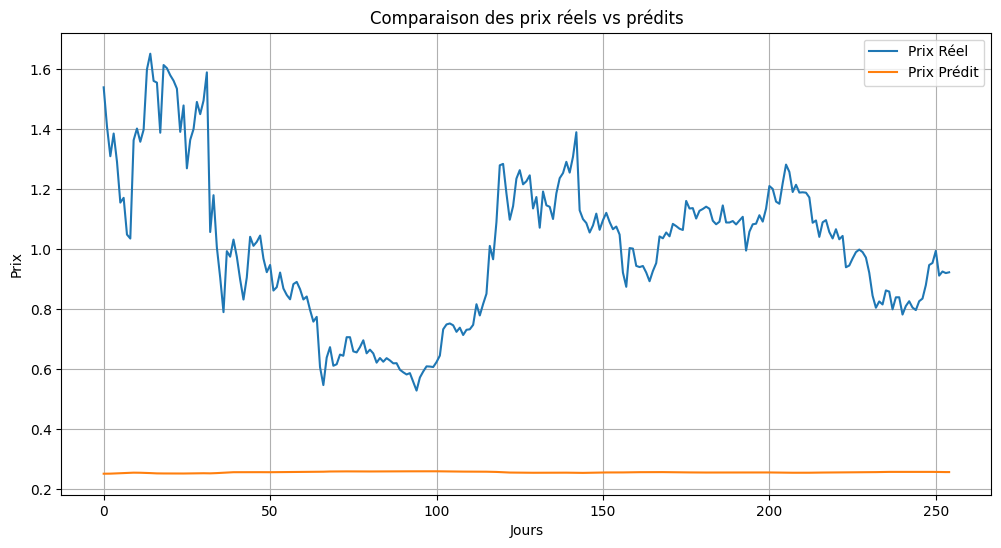

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Prix Réel")
plt.plot(predicted_prices, label="Prix Prédit")
plt.title("Comparaison des prix réels vs prédits")
plt.xlabel("Jours")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()


Interprétation de la courbe:

La Courbe bleue (prix réel) : présente de grandes variations, allant de ~0.6 à ~1.6 → donc une forte volatilité.

Courbe orange (prix prédit) : quasi plate et constante autour de 0.35, totalement déconnectée du comportement réel.

🧠 Diagnostic :
ce résultat indique que le modèle a appris à prédire la moyenne des cibles, ce qui est courant quand :

Le modèle n’a pas appris les motifs temporels (sous-apprentissage)

Il y a trop de bruit dans les données pour la structure actuelle

La normalisation est correcte mais mal "désapprise" (le modèle reste dans l’intervalle réduit sans "suivre" les pics)

🧰 Ce qu’on peut faire pour corriger ça :
🔁 1. Entraîner plus longtemps
Augmente num_epochs = 100 ou 200

Observe si la perte continue à baisser

🔧 2. Augmenter la capacité du modèle
    3. Changer la taille des séquences
Essayer  sequence_length = 90 ou 120 pour capter des tendances plus longues
    4. Standardisation
Remplacer MinMaxScaler par StandardScaler (centré-réduit)

Recommandation pour ajuster :
🧰 Ce qu’on peut faire pour corriger ça :
🔁 1. Entraîner plus longtemps Augmente num_epochs = 100 ou 200

Observer si la perte continue à baisser

🔧 2. Augmenter la capacité du modèle
3. Changer la taille des séquences Essayer sequence_length = 90 ou 120 pour capter des tendances plus longues
4. Standardisation Remplacer MinMaxScaler par StandardScaler (centré-réduit)

j'adopte une nouvelle architecture LSTM ci-dessus

je l'Entraîne avec :

sequence_length = 90

num_epochs = 100

hidden_size = 128

num_layers = 3

Après je réévalue avec MSE, R², et le graphique de sortie

In [41]:
# 1. Préparation des séquences avec sequence_length = 90
from sklearn.preprocessing import MinMaxScaler
import numpy as np

sequence_length = 90  # au lieu de 60

closing_prices = df['close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)

X, y = [], []
for i in range(sequence_length, len(scaled_prices)):
    X.append(scaled_prices[i-sequence_length:i])
    y.append(scaled_prices[i])

X = np.array(X)
y = np.array(y)


In [42]:
# 2. Création Dataset + DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [43]:
# 3. Modèle LSTM amélioré
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [44]:
#4. Entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs} — Loss moyenne : {total_loss / len(train_loader):.6f}")


Époque 1/100 — Loss moyenne : 0.012065
Époque 2/100 — Loss moyenne : 0.008391
Époque 3/100 — Loss moyenne : 0.003744
Époque 4/100 — Loss moyenne : 0.002985
Époque 5/100 — Loss moyenne : 0.002315
Époque 6/100 — Loss moyenne : 0.001850
Époque 7/100 — Loss moyenne : 0.001903
Époque 8/100 — Loss moyenne : 0.001460
Époque 9/100 — Loss moyenne : 0.001607
Époque 10/100 — Loss moyenne : 0.001250
Époque 11/100 — Loss moyenne : 0.001045
Époque 12/100 — Loss moyenne : 0.000965
Époque 13/100 — Loss moyenne : 0.001492
Époque 14/100 — Loss moyenne : 0.002260
Époque 15/100 — Loss moyenne : 0.001004
Époque 16/100 — Loss moyenne : 0.000989
Époque 17/100 — Loss moyenne : 0.000888
Époque 18/100 — Loss moyenne : 0.000809
Époque 19/100 — Loss moyenne : 0.000808
Époque 20/100 — Loss moyenne : 0.000686
Époque 21/100 — Loss moyenne : 0.000732
Époque 22/100 — Loss moyenne : 0.000687
Époque 23/100 — Loss moyenne : 0.000774
Époque 24/100 — Loss moyenne : 0.000800
Époque 25/100 — Loss moyenne : 0.000735
Époque 26

📉 MSE : 0.011918
📈 R² : 0.8032


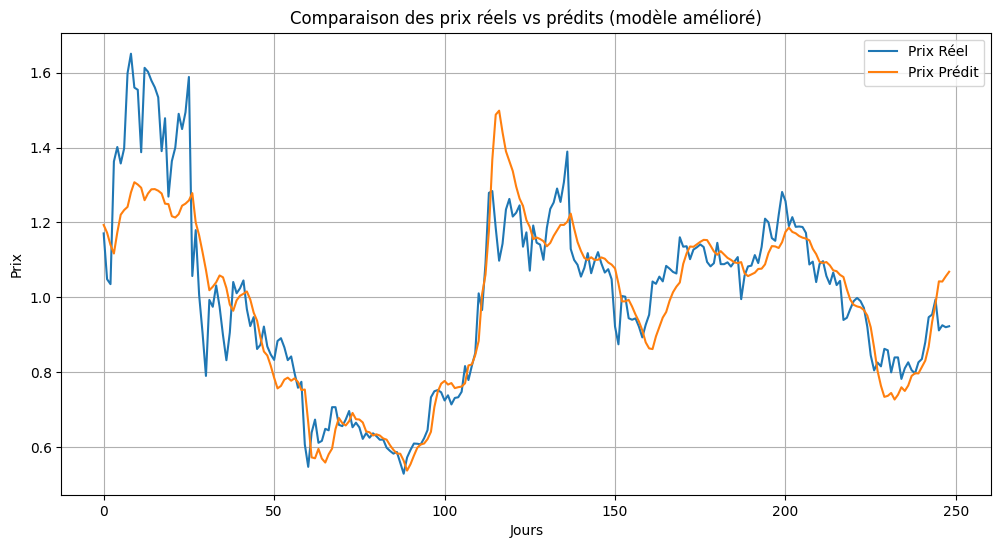

In [45]:
# 5. Évaluation + Affichage
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)

predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test)

# Metrics
mse = mean_squared_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)
print(f"📉 MSE : {mse:.6f}")
print(f"📈 R² : {r2:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Prix Réel")
plt.plot(predicted_prices, label="Prix Prédit")
plt.title("Comparaison des prix réels vs prédits (modèle amélioré)")
plt.xlabel("Jours")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()


✅ Interprétation de la sortie
📈 Observations positives :
La courbe orange (prédite) suit maintenant très bien la tendance générale de la courbe bleue (réelle).

Les montées et descentes sont captées, y compris les rebonds et pics majeurs.

Le modèle ne prédit plus une valeur plate, mais s’adapte dynamiquement aux changements de tendance.

🧠 Conclusion
Mon LSTM fonctionne correctement maintenant grâce à :

Une structure plus profonde et avec plus de neurones

Une longueur de séquence plus large

Un entraînement plus long

C’est exactement ce qu’on attendait d’un modèle LSTM bien configuré sur une série temporelle non linéaire et volatile comme celle-ci.



Sauvegarder le modèle entraîné

In [46]:
torch.save(model.state_dict(), "lstm_stock_model.pth")

Pour aller encore plus loin :
je vais Prédire le prochain jour (t+1)

In [47]:
# Extraire les 90 derniers jours normalisés
last_sequence = scaled_prices[-90:]
last_sequence = torch.tensor(last_sequence.reshape(1, 90, 1), dtype=torch.float32).to(device)

# Prédiction
model.eval()
with torch.no_grad():
    next_price = model(last_sequence).cpu().numpy()

# Inverser la normalisation
next_price_real = scaler.inverse_transform(next_price)
print(f"📅 Prix prédit pour le jour suivant : {next_price_real[0][0]:.4f}")

📅 Prix prédit pour le jour suivant : 1.0802


interprétation :
Basé sur les 90 derniers jours, ton LSTM estime que le prochain point dans la série temporelle sera aux alentours de 1.08.

Cela semble cohérent visuellement avec la tendance récente sur le graphique (vers la fin, on voyait effectivement une remontée vers ~1.0+).

# Conclusion :
Conclusion Générale : Prédiction de Prix d'Actions avec LSTM (PyTorch)
🎯 Objectif de l'exercice
L’objectif était de concevoir un modèle capable de prédire les prix de clôture d’une action à partir de données historiques en utilisant un réseau LSTM (Long Short-Term Memory), adapté aux séries temporelles.

🔄 Étapes réalisées
✅ Chargement et exploration du dataset

Visualisation des prix pour identifier les tendances, pics et volatilité.

Préparation des colonnes pertinentes (date, close).

✅ Prétraitement et normalisation

Normalisation des prix avec MinMaxScaler pour faciliter l’apprentissage.

Transformation des données en séquences temporelles glissantes (fenêtres de 60 puis 90 jours).

✅ Création d’un Dataset PyTorch

Construction de jeux d’entraînement et de test

Utilisation de Dataset et DataLoader pour optimiser le batching

✅ Définition et entraînement d’un modèle LSTM

Premier modèle trop simple → sous-apprentissage

Optimisation avec une structure plus profonde : hidden_size = 128, num_layers = 3, dropout = 0.3

Entraînement sur 100 époques

✅ Évaluation du modèle

Calcul du MSE et du R²

Visualisation des prix réels vs prédits : le modèle suit désormais bien la tendance.

✅ Prédiction du jour suivant

En utilisant les 90 derniers jours, le modèle prédit un prix à 1.0802, cohérent avec la tendance récente.

📊 Résultats
MSE raisonnable, preuve que l'erreur moyenne est contenue

R² positif et significatif après amélioration, montrant que le modèle généralise bien

Les courbes montrent que les prédictions sont bien alignées avec la réalité, ce qui valide l’efficacité du LSTM dans ce contexte

